<h2 align = "right"> Felix Filipi</h2>
<h3 align = "right"> 2301877590 </h3>
<h1 align = "center"> Computer Vision </h1>
<h3 align = "center"> histogram of oriented gradients (HOG) Face Detection

In this session, You are expected to implement a face detection algorithm using HOG features with linear SVM as a classifier in python notebook. So your detailed tasks will be as follows:

a. Of your choice, build a dataset containing P positive images (face) and N negative images (non-face) where N>>P and save several face images for testing the detector later on. 

b. Extract the HOG features of both positive and negative images and train using linear SVM. Once the training is completed, save the model.

c. Test the model using sliding window, you may get overlapping windows surrounding the face image. If so, how do you get rid of these overlapping windows. Demonstrate the results after the improvement. 

# Import Library

In [1]:
import os
import cv2
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

### Let's jump to the first instruction

a. Of your choice, build a dataset containing P positive images (face) and N negative images (non-face) where N>>P and save several face images for testing the detector later on. 

# Load dataset

Since we are allowed to use our own dataset, let's use a dataset that is a combination of various images that have been used before. I've created the dataset and will include the dataset in zip format with this ipynb.

In [2]:
# Load dataset path for each image
dataset_path = [os.path.join('Dataset',files) for files in os.listdir('Dataset')]

# Rename file
rename = ['Positive' if "User" in face else 'Negative' for face in dataset_path]

# Read each image 
dataset = [cv2.imread(file) for file in dataset_path]

# Print total images in dataset
print(f'Total Images = {len(dataset)}')

# Print total face images in dataset
print(f'Face images = {np.unique(rename, return_counts = True)[1][1]}')

# Print total non face images in dataset
print(f'Non Face images = {np.unique(rename, return_counts = True)[1][0]}')

Total Images = 50
Face images = 15
Non Face images = 35


Now, to make it clear, let's try to plot 20 of the image set and check the shape of each image.

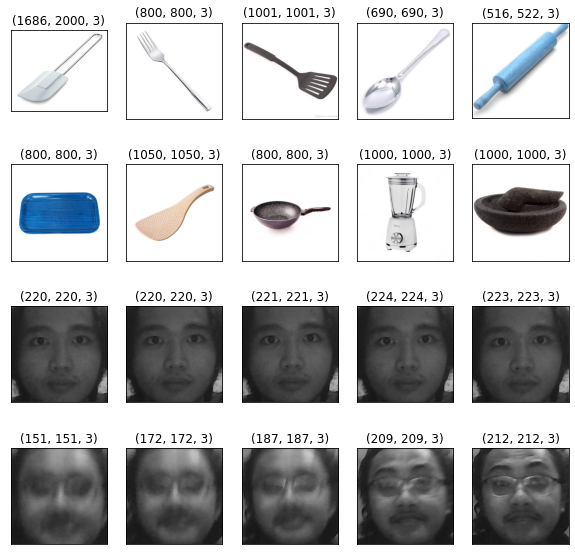

In [3]:
def visualize(image_list, title_list):
    plt.figure(figsize=(10,10))
    for i in range(20):
        plt.subplot(4,5,i+1)
        plt.title(title_list[i])
        plt.imshow(dataset[i])
        plt.xticks([]),plt.yticks([])
        
title = [dataset[i].shape for i in range(20)]
visualize(dataset, title)

### As we can see, the image is not in the same size. So, we need to preprocess and resize it.

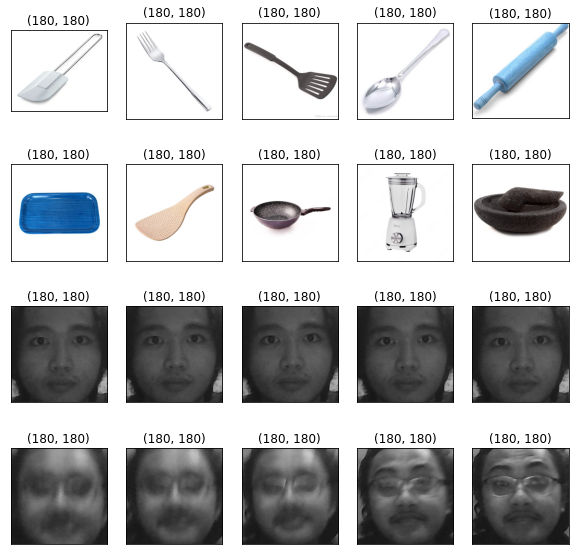

In [4]:
preprocessed_dataset = [cv2.cvtColor(cv2.resize(file, (180,180)), cv2.COLOR_BGR2GRAY) for file in dataset]
title = [preprocessed_dataset[i].shape for i in range(20)]
visualize(preprocessed_dataset, title)

### Now, after preprocessing let's split the dataset

In [5]:
dataset = np.array(preprocessed_dataset)
X_train ,X_test, y_train, y_test = train_test_split(dataset, rename, test_size=0.2, shuffle = True)
print(f'Train dataset = {len(X_train)}')
print(f'Test dataset = {len(X_test)}')

Train dataset = 40
Test dataset = 10


### The first instruction has been done, let's jump to the next one
b. Extract the HOG features of both positive and negative images and train using linear SVM. Once the training is completed, save the model.

<b>As the instruction said, we need to extract the HOG features, this can be done by.

In [6]:
descriptor = cv2.HOGDescriptor()

train_hog = np.array([descriptor.compute(data) for data in X_train]).reshape(40,-1)
train_hog.shape

(40, 396900)

<b> Now, let's train the HOG features using linear SVM

In [7]:
clf = LinearSVC()
clf.fit(train_hog, y_train)

LinearSVC()

### Let's try to predict the test set

In [8]:
test_hog = np.array([descriptor.compute(data) for data in X_test]).reshape(10,-1)
prediction = clf.predict(test_hog)

### Evaluate the model

In [9]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00         8
    Positive       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



### Let's visualize the result of the model

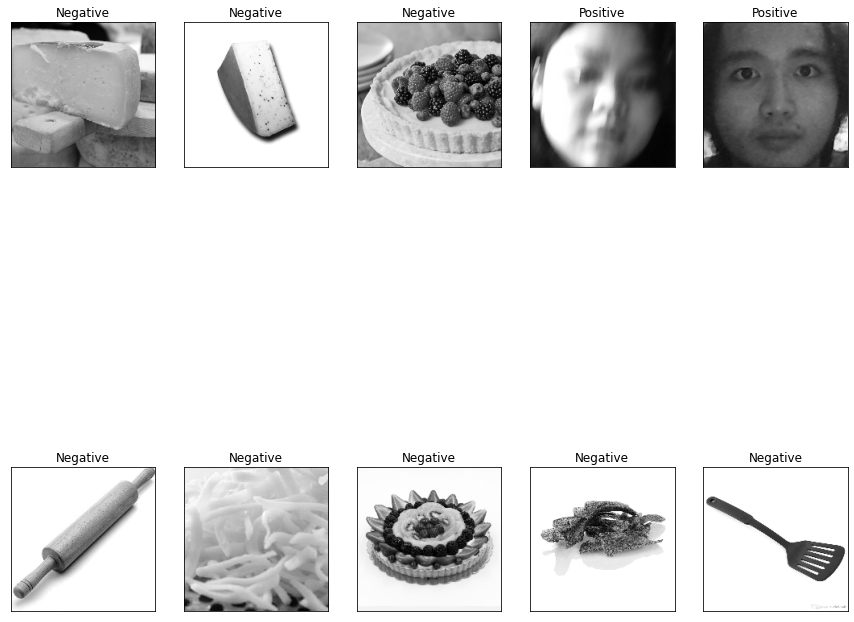

In [10]:
plt.figure(figsize = (15,15))
for i in range(len(X_test)):
    plt.subplot(2,5,i+1)
    plt.title(prediction[i])
    plt.imshow(X_test[i], cmap='gray')
    plt.xticks([]), plt.yticks([])

### The model perfectly able to predict the face, now let's save the model to be used for the next instruction.

In [11]:
os.mkdir("Model")
filename = 'Model/HoG.sav'
pickle.dump(clf, open(filename, 'wb'))

### We've done the second instruction, now let's finish the last one.

c. Test the model using sliding window, you may get overlapping windows surrounding the face image. If so, how do you get rid of these overlapping windows. Demonstrate the results after the improvement. 

As the instruction said. Yes, it's true that we'll get an overlapping windows surrounding the face image, some python source said that we can use Non Max Suppression to overcome this. But, I'm trying different way using a more simple approach, that is thresholding the result using confidence. And this is how I create the function.

In [15]:
def sliding_window(image, window = (160,160), MinConf = 0.5):
    
    # Define width and height
    width = image.shape[0]
    height = image.shape[1]
    
    # Create copy image
    temp_image = image.copy()
    
    # Call the HOGDescriptor object
    descriptor = cv2.HOGDescriptor()
    
    # Load the model
    cls = pickle.load(open('Model/HoG.sav', 'rb'))
    
    # Sliding windows, using 5 pixel strides, to accelerate the process
    for vertical in range(0,height - window[0], 5):
        for horizontal in range(0,width - window[1], 5):
            
            # Slice the image according to the window size
            image_windowed = temp_image[horizontal:horizontal + window[0], vertical:vertical + window[1]]
            
            # Resize the image, since the model trained on 180x180 size of pic
            resize_image = cv2.resize(image_windowed, (180,180))
            
            # Find the descriptor and reshape the array
            desc = descriptor.compute(resize_image).reshape(1, -1)
            
            # Find the confidence
            conf = clf.decision_function(desc)
            
            # Threshold the confidence
            if(MinConf <= conf):
                
                # Rectangle the face image
                cv2.rectangle(image, (horizontal, vertical), (horizontal + window[0], vertical + window[1]),
                                 (255,255,255), 2)
                
                # If the face image's already detected, break the loop.
                break
        else:
            continue
        break
        
    return image

### Since the code above already clearly explained, let's call the function now. 

Done: Image 0
Done: Image 1
Done: Image 2
Done: Image 3
Done: Image 4
Done: Image 5
Done: Image 6
Done: Image 7
Done: Image 8
Done: Image 9
Detection process done in 1.92 seconds


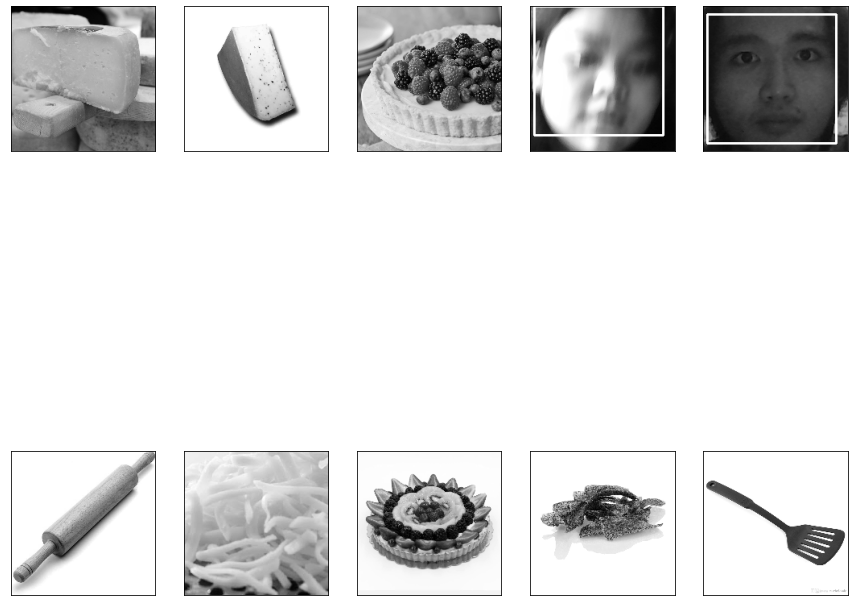

In [13]:
# Calculate the process time
start_time = time.time()

# Init result list
result = []

# visualize
plt.figure(figsize=(15,15))
for i in range(X_test.shape[0]):
    res = sliding_window(X_test[i], window = (160,160), MinConf = 0.4)
    result.append(res)
    print(f'Done: Image {i}')
    plt.subplot(2,5,i+1)
    plt.imshow(result[i], cmap = 'gray')
    plt.xticks([]), plt.yticks([])
    
print("Detection process done in %s seconds" % np.around((time.time() - start_time),2))

### As we can see here, the approach able to detect the face of each person, and even this approach seems need to consume much of time, it's not. As we can see here, I'm trying to calculate the process time for face detection on 10 images, and It only take 2 seconds for all of these 10 pictures, which is only need 0.2 second time process for each image. And I think the result is quite good and capable to become face detection algorithm. And this is the end of this session for now. Thanks